In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score, auc, average_precision_score, brier_score_loss)
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve

import joblib
import pickle

ImportError: cannot import name 'STRING_TYPES' from 'xgboost.compat' (/Users/celestinesheum/Desktop/MY-DAC-Curriculum/.venv/lib/python3.12/site-packages/xgboost/compat.py)

In [ ]:
df = pd.read_csv('./dataset/Heart_explored.csv')

# XGBoost Classifier Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Likelihood of Death Model Accuracy: 72.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.66      0.73     49030
           1       0.66      0.80      0.72     39965

    accuracy                           0.72     88995
   macro avg       0.73      0.73      0.72     88995
weighted avg       0.74      0.72      0.72     88995


 Confusion Matrix:
[[32363 16667]
 [ 7836 32129]]


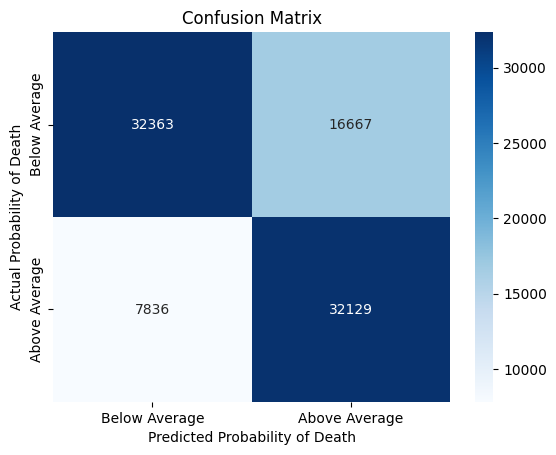

In [ ]:
chronic_threshold = df['ChronicConditionCount'].quantile(0.5)  # Top 25%
comorbidity_threshold = df['ComorbidityCount'].quantile(0.5)  # Top 25%
impairment_threshold = df['ImpairmentCount'].quantile(0.5)  # Top 25%

df['MortalityLikelihood_v1'] = (
    (df['ChronicConditionCount'] > chronic_threshold) | 
    (df['ComorbidityCount'] > comorbidity_threshold) | 
    (df['ImpairmentCount'] > impairment_threshold) |
    ((df['ChronicConditionCount'] + df['ComorbidityCount'] + df['ImpairmentCount']) > 4)
).astype(int)
# so 1 (true) is indv above average likelihood of death ie more than 2 comorbidities


X = df[['Sex_numeric', 'AgeCategory_numeric', 'RaceEthnicityCategory_numeric', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'SleepHours_Classification_numeric', 'CalculatedBMI_Classification_numeric', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver']]
y = df['MortalityLikelihood_v1']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create XGBoost classifier model
xgb_modelb = XGBClassifier(random_state=42, scale_pos_weight = 2.92)


# Define hyperparameter grid for tuning
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # How much to adjust the weights after each iteration
    'n_estimators': [100, 200, 300],  # Number of boosting rounds (trees)
    'max_depth': [3, 6, 10],  # Depth of trees (higher = more complex)
    'subsample': [0.8, 1.0],  # Fraction of samples to use in training (helps avoid overfitting)
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree (helps avoid overfitting)
    'scale_pos_weight': [1, 2.92]  # Adjust to account for class imbalance (this depends on the ratio of class 1 to class 0)
}

# Use StratifiedKFold for cross-validation (preserves class distribution)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search
random_search = RandomizedSearchCV(estimator=xgb_modelb, param_distributions=param_distributions, 
                                   cv=cv, n_jobs=-1, scoring='roc_auc', verbose=1, n_iter=50, random_state=42)
# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Best model after randomized search
best_xgb_modelb = random_search.best_estimator_



# Make predictions
y_probs = best_xgb_modelb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)  

# Find the threshold that gives the highest F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

# Make final predictions using the optimized threshold
y_pred = (y_probs > best_threshold).astype(int)



if 'MortalityLikelihood_v1_predicted' not in df.columns:
    df['MortalityLikelihood_v1_predicted'] = np.nan

df.loc[y_test.index, 'MortalityLikelihood_v1_predicted'] = y_pred




# -------------------------------------------------------------------------------------------

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

# Print results
print(f'Likelihood of Death Model Accuracy: {accuracy * 100:.2f}%')
print('\nClassification Report:\n', classification_report_output)


cm = confusion_matrix(y_test, y_pred)
print('\n', f"Confusion Matrix:\n{cm}")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Below Average', 'Above Average'], yticklabels=['Below Average', 'Above Average'])
plt.ylabel('Actual Probability of Death')
plt.xlabel('Predicted Probability of Death')
plt.title('Confusion Matrix')
plt.show()

### ROC and AUC

ROC AUC: 0.8184


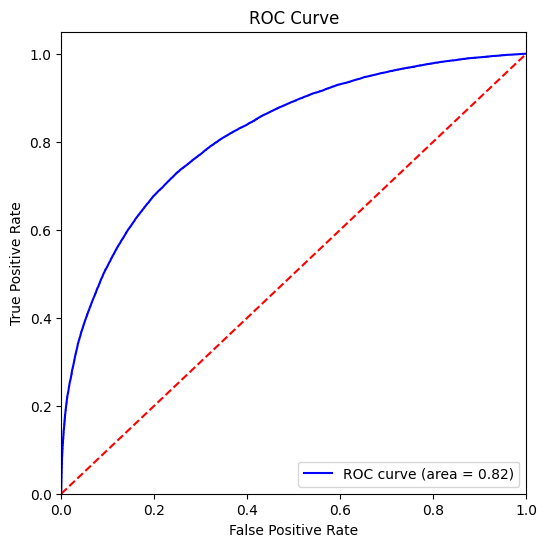

In [ ]:

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve and Average Precision

Average Precision (AP): 0.7967


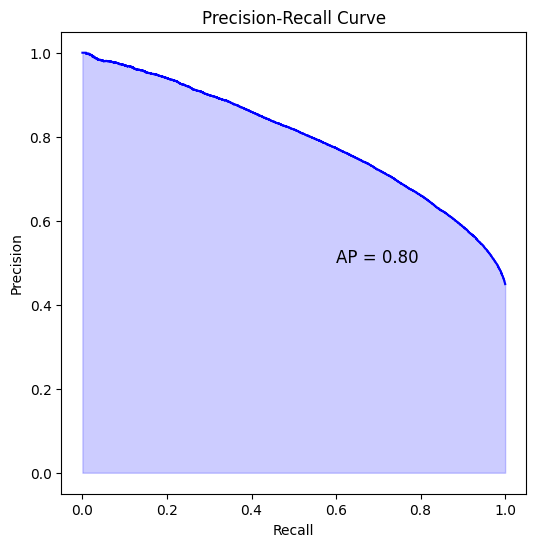

In [ ]:

precision, recall, _ = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

print(f"Average Precision (AP): {ap_score:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(6,6))
plt.step(recall, precision, where='post', color='blue')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.text(0.6, 0.5, f"AP = {ap_score:.2f}", fontsize=12)
plt.show()

### Brier Score

Brier Score: 0.1718


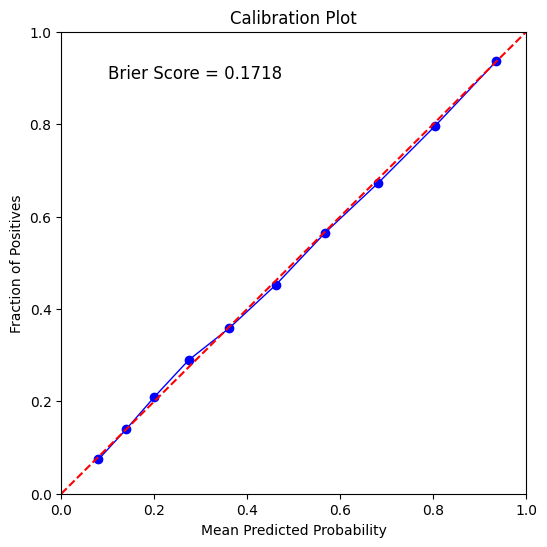

In [ ]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='quantile')

# Compute Brier Score
brier = brier_score_loss(y_test, y_probs)
print(f"Brier Score: {brier:.4f}")

# Plot calibration curve
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.text(0.1, 0.9, f"Brier Score = {brier:.4f}", fontsize=12)
plt.show()

# Saving Model + Threshold

In [ ]:
# Save the best model
joblib.dump(best_xgb_modelb, 'best_xgb_modelb.pkl')

# Save the best threshold
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print("Model and threshold saved successfully.")

Model and threshold saved successfully.
